In [41]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm, tqdm_notebook

[autoreload of sklearn.externals.six failed: Traceback (most recent call last):
  File "/Users/sunhwan/miniconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/sunhwan/miniconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 384, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/sunhwan/miniconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 323, in update_generic
    update(a, b)
  File "/Users/sunhwan/miniconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 275, in update_class
    old_obj = getattr(old, key)
  File "/Users/sunhwan/miniconda3/lib/python3.6/site-packages/sklearn/externals/six.py", line 87, in __get__
    setattr(obj, self.name, result)
AttributeError: 'NoneType' object has no attribute 'cStringIO'
]
[autoreload of sklearn.externals.joblib.numpy_pickle failed: Traceback (most recent call last

In [42]:
import numba
from math import *
import random

In [43]:
x = np.arange(101)

In [44]:
w = 30
p = 0.5 * np.exp(-(x-12)**2/w) + \
    0.8 * np.exp(-(x-37)**2/w) + \
    1.0 * np.exp(-(x-65)**2/w) + \
    0.5 * np.exp(-(x-87)**2/w)
p = p / np.sum(p)

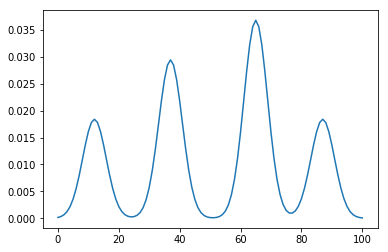

In [45]:
plt.plot(x, p)
plt.show()

In [46]:
@numba.jit('f8(f8)', nopython=True)
def potential(x):
    w = 30
    p = 0.5 * exp(-(x-12)**2/w) + \
        0.8 * exp(-(x-37)**2/w) + \
        1.0 * exp(-(x-65)**2/w) + \
        0.5 * exp(-(x-87)**2/w)
    return -log(p)

@numba.jit('f8(f8, f8, f8, f8)', nopython=True)
def new_position(pos, stepsize, min, max):
    direction = 1 if (random.random() > 0.5) else -1
    new_pos = pos + (random.random()*stepsize) * direction
    if new_pos < min or new_pos > max:
        return new_position(pos, stepsize, min, max)
    else:
        return new_pos

@numba.jit('f8[:](f8, i8, i8, f8, f8, f8)', nopython=True)
def run_mc(pos, step, interval, stepsize, min, max):
    pot = potential(pos)
    traj = []
    for i in range(step):
        new_pos = new_position(pos, stepsize, min, max)
        new_pot = potential(new_pos)
        diff = new_pot - pot
        crit = True if diff < 0 or exp(-diff/0.6) > random.random() else False
        if crit:
            pos = new_pos
            pot = new_pot
        if i % interval == 0:
            traj.append(pos)
    return np.array(traj)

class simulation():
    def __init__(self):
        self.traj = []
        self.stepsize = 0.5
        self.boundary = [0, 100]
        self.set_position(0)
        self.interval = 10
    
    def set_position(self, x):
        self.pos = x
        self.pot = potential(x)
        
    def run_mc(self, step):
        traj = run_mc(self.pos, step, self.interval, self.stepsize, self.boundary[0], self.boundary[1])
        self.traj = traj
        self.pos = traj[-1]
        self.pot = potential(self.pos)

In [49]:
from glob import glob
outputdir = 'output/naive_kmeans_1000_1000/'
n_cycle = len(glob(f'{outputdir}/*_0.npy'))
n_rep = len(glob(f'{outputdir}/0_*.npy'))
trajs = []
print(n_cycle)
for i in range(n_cycle):
    for j in range(n_rep):
        fn = f'{outputdir}/{i}_{j}.npy'
        trajs.append(np.load(fn)[np.newaxis, :].T)

1000


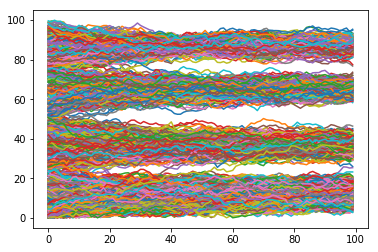

In [50]:
for i in range(len(trajs)):
    x = range(len(trajs[i]))
    y = trajs[i]
    plt.plot(x, y)

In [62]:
from msmbuilder.msm import MarkovStateModel
from msmbuilder.cluster import RegularSpatial, KMeans
msm = MarkovStateModel(lag_time=10, n_timescales=10)
cluster = RegularSpatial(d_min=1)
#cluster = KMeans(n_clusters=100)

In [63]:
dtraj = cluster.fit_transform(trajs)

In [64]:
msm.fit(dtraj)

MSM contains 2 strongly connected components above weight=0.10. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff='on', lag_time=10, n_timescales=10,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

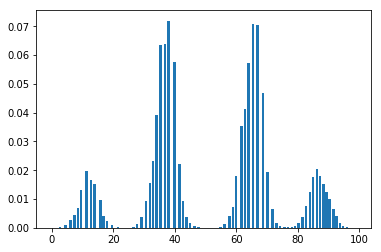

In [65]:
x = cluster.cluster_centers_[msm.state_labels_, 0]
pi = msm.populations_
plt.bar(x, pi)
plt.show()

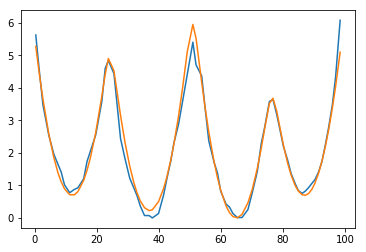

In [66]:
xi = np.argsort(cluster.cluster_centers_[msm.state_labels_, 0])
x = cluster.cluster_centers_[msm.state_labels_, 0][xi]
y = -0.6*np.log(pi[xi])
y -= np.min(y)
plt.plot(x, y)

y = [potential(_) for _ in x]
plt.plot(x, y)
plt.show()

In [151]:
from glob import glob
from scipy.stats import entropy

def collect(base, n_cycle):
    trajs = []
    for i in range(n_cycle):
        n_rep = len(glob(f'{base}/{i}_*.npy'))
        for j in range(n_rep):
            fn = f'{base}/{i}_{j}.npy'
            trajs.append(np.load(fn)[np.newaxis, :].T)
    return trajs

def model(trajs):
    msm = MarkovStateModel(lag_time=10, n_timescales=10, verbose=False)
    cluster = RegularSpatial(d_min=1)
    cluster.cluster_centers_ = np.array([[c] for c in np.arange(0, 101, 0.5)])
    dtraj = cluster.transform(trajs)
    msm.fit(dtraj)
    return cluster, msm

pis = []
pis_ = []
kls = []

for i in tqdm_notebook(range(1, 11)):
    begin = 0
    end = i * 100
    trajs = collect('output/naive_regular_1000_1000', end)
    cluster, msm = model(trajs)
    
    # predicted pi
    x = cluster.cluster_centers_[:, 0]
    pi = np.zeros_like(x)
    for si, ix in enumerate(msm.state_labels_):
        pi[ix] = msm.populations_[si]
    
    y = np.array([potential(_) for _ in x])
    pi_ = np.exp(-y/0.6)
    kl = entropy(pi, pi_)
    
    pis.append(pi)
    pis_.append(pi_)
    kls.append(kl)

In [152]:
for i in range(10):
    y = -0.6*np.log(np.sum(pis[i][155:195])/np.sum(pis[i]))
    y_ = -0.6*np.log(np.sum(pi_[155:195])/np.sum(pi_))
    print(y - y_)

inf
1.0760176054291617
0.7588478845878055
0.24282826597837937
0.39514022645125
0.401994294941072
0.44961011571417253
0.25454127518481573
0.25056063919626737
0.24708537567195643


/Users/sunhwan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


/Users/sunhwan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


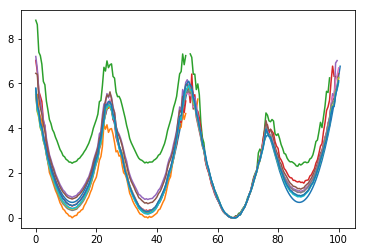

In [153]:
y = np.array([potential(_) for _ in x])
pi_ = np.exp(-y/0.6)
plt.plot(x, y)

for i in range(10):
    y = -0.6*np.log(pis[i])
    y -= np.min(y)
    plt.plot(x, y)
plt.show()

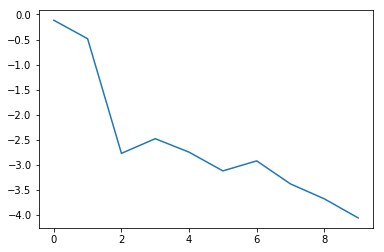

In [154]:
plt.plot(np.arange(10), np.log(kls))

In [145]:
pis = []
pis_ = []
kls = []

for i in tqdm_notebook(range(1, 11)):
    begin = 0
    end = i * 100
    trajs = collect('output/naive_kmeans_1000_1000', end)
    cluster, msm = model(trajs)
    
    # predicted pi
    x = cluster.cluster_centers_[:, 0]
    pi = np.zeros_like(x)
    for si, ix in enumerate(msm.state_labels_):
        pi[ix] = msm.populations_[si]
    
    y = np.array([potential(_) for _ in x])
    pi_ = np.exp(-y/0.6)
    kl = entropy(pi, pi_)
    
    pis.append(pi)
    pis_.append(pi_)
    kls.append(kl)

In [146]:
for i in range(10):
    y = -0.6*np.log(np.sum(pis[i][155:195])/np.sum(pis[i]))
    y_ = -0.6*np.log(np.sum(pi_[155:195])/np.sum(pi_))
    print(y - y_)

inf
inf
inf
inf
inf
-0.17725003127895045
0.22746194433728273
0.011647481425672623
0.17184880640573952
0.06836321201512408


/Users/sunhwan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


/Users/sunhwan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


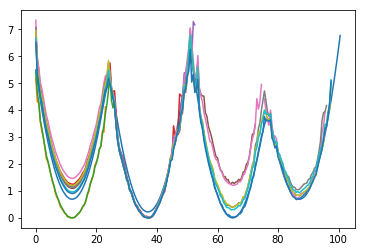

In [147]:
y = np.array([potential(_) for _ in x])
pi_ = np.exp(-y/0.6)
plt.plot(x, y)

for i in range(10):
    y = -0.6*np.log(pis[i])
    y -= np.min(y)
    plt.plot(x, y)
plt.show()

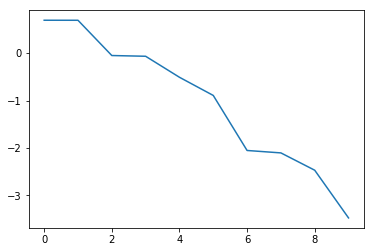

In [149]:
plt.plot(np.arange(10), np.log(kls))